<img src='https://data.cityofchicago.org/api/assets/73F1665C-0FE6-4183-8AD1-E91DB8EFAFA4?7CB02402-8E06-48B0-8C9A-3890182D58C7.png'>

# Analyze Data Using English - A Behind-the-Scene Look
### With Eric Vogelpohl - Field CTO, Presidio

## Demo Objectives: 
* Similar to RAG with <b>unstructured</b> data (PDFs, TXT, HTML/FAQs, DOCs). Use LLMs with <b>structured<b> data
* English as the analytical language - Working with a LLM over structured (table) data.
* Demostrate how data catalogs can <b>enrich</b> and help maintain <b>privacy</b>.

In [1]:
import pandas as pd
crimes = pd.read_csv('https://raw.githubusercontent.com/evogelpohl/pandasAI_project/main/chicago_iucr.csv')

import warnings
warnings.filterwarnings('ignore')

# Setup the Pandas_AI Session <br>

### Setup: Privacy: Create a FAKE PREVIEW Data - Prevent the LLM from 'seeing' our real data.

In [2]:
# I've created fake data here to replicate what ours looks like

fake_data = {
    "date": ["2099-03-14", "2099-03-14", "2099-03-14"],
    "block": ["033XX S KEDZIE AVE", "093XX S VINCENNES AVE", "117XX S HALSTED ST"],
    "location_description": ["STREET", "STREET", "RESIDENCE"],
    "arrest": [False, True, False],
    "domestic": [False, False, True],
    "beat": [1033, 635, 525],
    "district": [10, 6, 5],
    "ward": [22, 21, 34],
    "community_area": [28.0, 71.0, 55.0],
    "fbi_code": ["07", "04A", "14"],
    "year": [2024, 2024, 2024],
    "latitude": [41.827391, 41.722932, None],
    "longitude": [-87.705487, -87.653322, None],
    "location": [{"latitude": "41.827391", "longitude": "-87.705487"}, {"latitude": "41.722932", "longitude": "-87.653322"}, None],
    "crime": ["MOTOR VEHICLE THEFT - UNAUTHORIZED POSSESSION", "ASSAULT - AGGRAVATED - OTHER FIREARM", "CRIMINAL DAMAGE - TO VEHICLE"]
}

# Create the adjusted DataFrame
fake_example_df = pd.DataFrame(fake_data)


### Setup: Simulate a Data Catalog Feature: Columm Descriptions (aka, metadata)

In [3]:
field_descriptions = {
    "date": "The Date when the incident occurred. Stored as text.",
    "block": "Partially redacted address where the incident occurred, within the same block as the actual address.",
    "location_description": "Description of the location where the incident occurred.",
    "arrest": "Indicates whether an arrest was made.",
    "domestic": "Indicates whether the incident was domestic-related as per the Illinois Domestic Violence Act.",
    "beat": "Police beat where the incident occurred, part of the smallest police geographic area.",
    "district": "Police district where the incident occurred.",
    "ward": "City Council district (ward) where the incident occurred.",
    "community_area": "Indicates the community area where the incident occurred, with Chicago having 77 community areas.",
    "fbi_code": "Crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).",
    "latitude": "Latitude of the incident location, shifted for partial redaction but on the same block.",
    "longitude": "Longitude of the incident location, shifted for partial redaction but on the same block.",
    "crime": "The crime committed, aka the incident."
}


### Setup: Create the LLM settings for Pandas AI

In [4]:
# Retrieve the API key from environment variables

import os
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI
from pandasai.llm.local_llm import LocalLLM
from pandasai.llm import OpenAI
from pandasai.connectors import PandasConnector
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# Get my Openai Var Key
open_ai_key = os.getenv('OPENAI_API_KEY')

# Choose the model
select_model = 'OpenAI' #OpenAI $$, #AzureOpenAI #Presdio #Local MyModel mY Macbook

if select_model == 'Azure':
    # Define the LLM model for Azure (if True)
    azure_api_key = os.getenv('AZURE_OPENAI_API_KEY')
    azure_api_ver = os.getenv('AZURE_API_VERSION')
    azure_api_endpt = os.getenv('AZURE_OPENAI_ENDPOINT')
    azure_oai_deployment = os.getenv('AZURE_OPENAI_DEPLOYMENT')
    llm = AzureOpenAI(
        api_token=azure_api_key,
        azure_endpoint=azure_api_endpt,
        api_version=azure_api_ver,
        deployment_name=azure_oai_deployment,
        temperature=0,
        seed=26,
    )
elif select_model == 'OpenAI':
    openai_api_key = os.getenv('OPENAI_API_KEY')
    llm = OpenAI(model="gpt-4-1106-preview", api_token=openai_api_key, 
                 temperature=.2,
                 seed=35,
                )
    
elif select_model == 'Local':
    llm = LocalLLM(api_base="http://host.docker.internal:1234/v1",
                  temperature=0, 
                  seed=55,
                  )

# A description of the overall table
description = '''A dataset of all crimes committed in Chicago along with location, district, ward and date.'''
connector = PandasConnector({'original_df':crimes}, custom_head=fake_example_df, field_descriptions=field_descriptions, \
                            name='Chicago Crimes', description=description
                           )
df = SmartDataframe(connector, config={
                                        'llm': llm,
                                        'enable_cache': False,
                                        'verbose': False,
                                        'save_charts': False,
                                        'open_charts': True,
                                        #'save_charts_path': './saved_plots',
                                        }
                   )

# Explore the Data with QA <br>

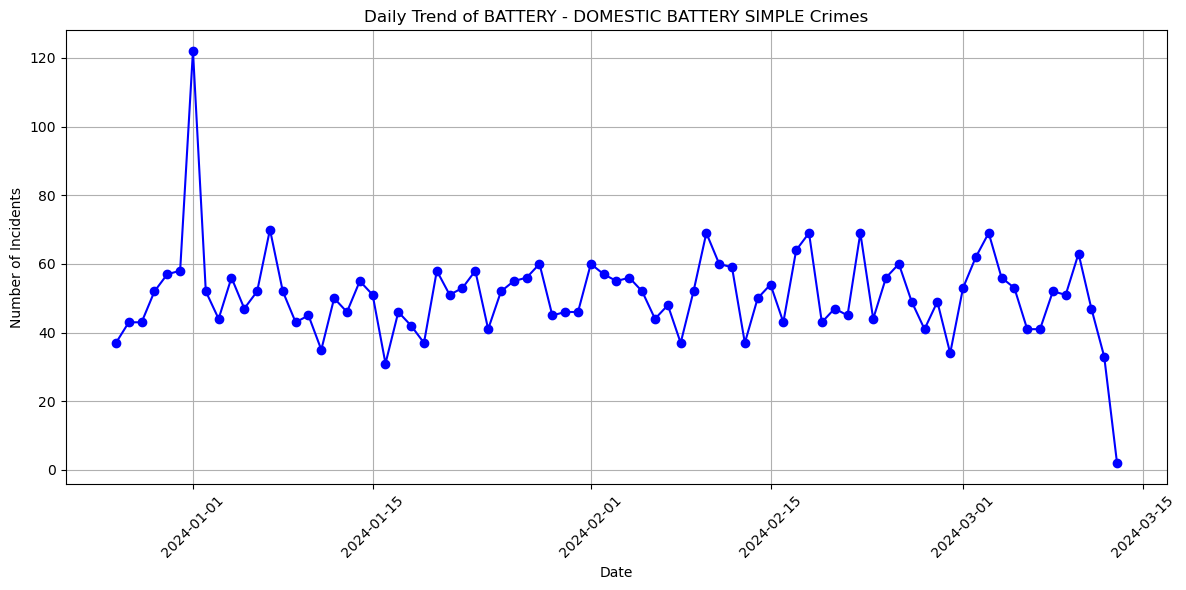

'/home/jovyan/devRoot/pandasAi/exports/charts/temp_chart.png'

In [7]:
#Ask the question: 
query = "Plot as a line chart the daily trend of the crime: ‘BATTERY - DOMESTIC BATTERY SIMPLE’ for all days available."

# Send the question & our fake data to OpenAI, returns the code to run
df.chat(query)

In [8]:
print(df.last_code_generated)

df = dfs[0]
battery_df = df[df['crime'] == 'BATTERY - DOMESTIC BATTERY SIMPLE']
battery_df['date'] = pd.to_datetime(battery_df['date'])
daily_trend = battery_df.groupby(battery_df['date'].dt.date).size()
plt.figure(figsize=(12, 6))
daily_trend.plot(kind='line', color='blue', marker='o')
plt.title('Daily Trend of BATTERY - DOMESTIC BATTERY SIMPLE Crimes')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jovyan/devRoot/pandasAi/exports/charts/temp_chart.png')
result = {'type': 'plot', 'value': '/home/jovyan/devRoot/pandasAi/exports/charts/temp_chart.png'}
plt.show()
